# Stock Market Forecasting

## Importing Relevant Libraries

In [60]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

## Reading In Data

In [37]:
ticker = 'IOZ.AX'
data = yf.Ticker(ticker)

## Data for 1 month

In [128]:
closed_prices_1month = data.history(period='1mo')['Close']
returns = closed_prices_1month.pct_change().dropna()

### EDA

Text(0, 0.5, 'Closed Prices')

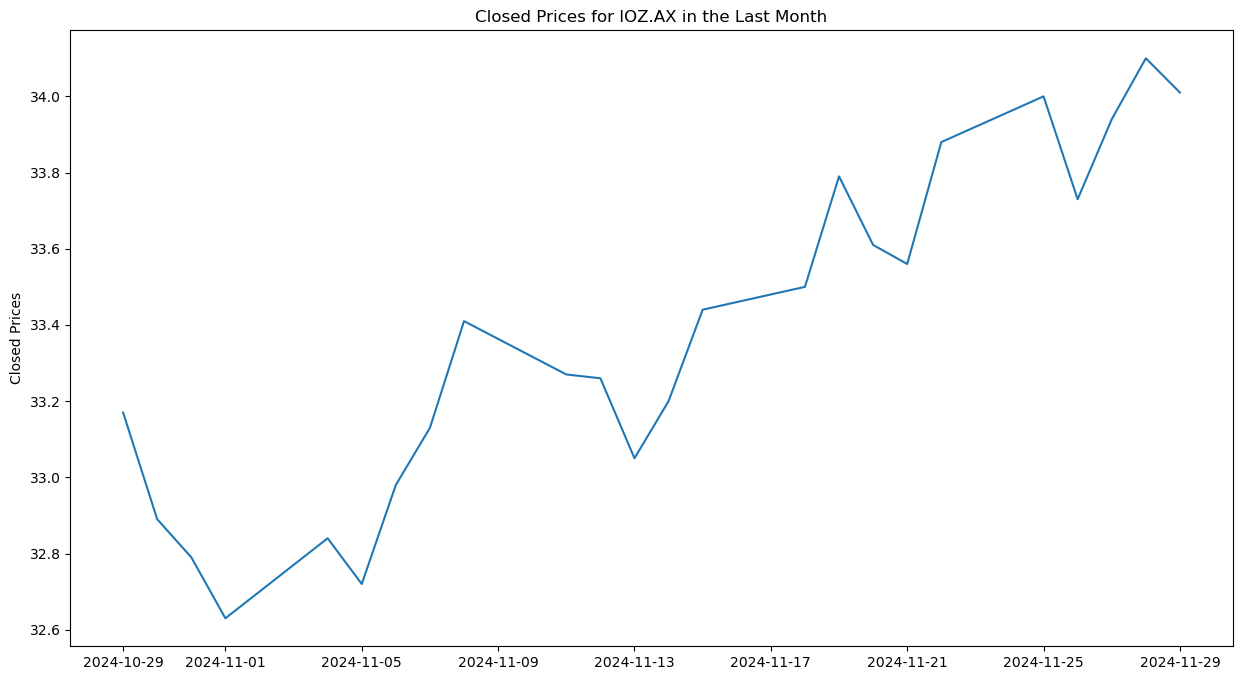

In [129]:
plt.figure(figsize=(15, 8))
plt.plot(closed_prices_1month)
plt.title('Closed Prices for IOZ.AX in the Last Month')
plt.ylabel('Closed Prices')

#### ACF and PACF Plots

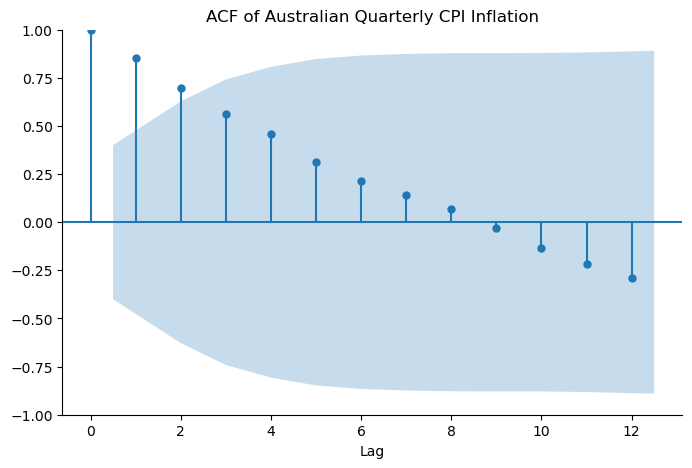

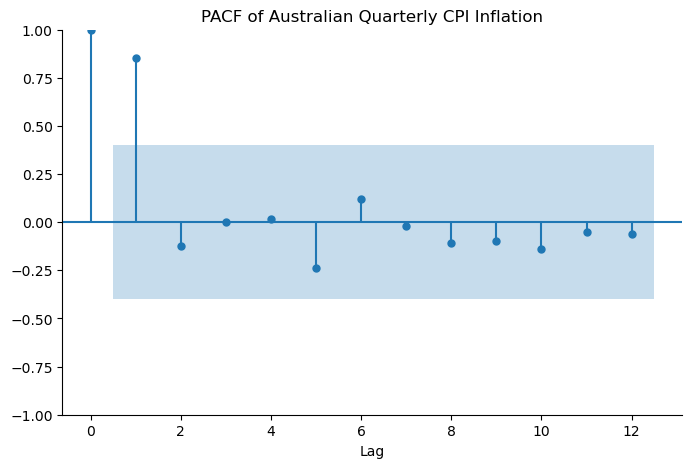

In [130]:
# ACF plots of the CPI data for 12 lags
fig_stock_acf, ax_stock_acf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(closed_prices_1month, lags=12,
                         ax=ax_stock_acf, alpha=0.05)
ax_stock_acf.set_xlabel('Lag')
ax_stock_acf.set_title('ACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

# PACF plots of the CPI data for 12 lags
fig_stock_pacf, ax_stock_pacf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_pacf(closed_prices_1month, lags=12,
                          ax=ax_stock_pacf, alpha=0.05)
ax_stock_pacf.set_xlabel('Lag')
ax_stock_pacf.set_title('PACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

### Model Development

#### Time Series Decomposition

In [131]:
window_size = 12
decomposition = seasonal_decompose(
    closed_prices_1month, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

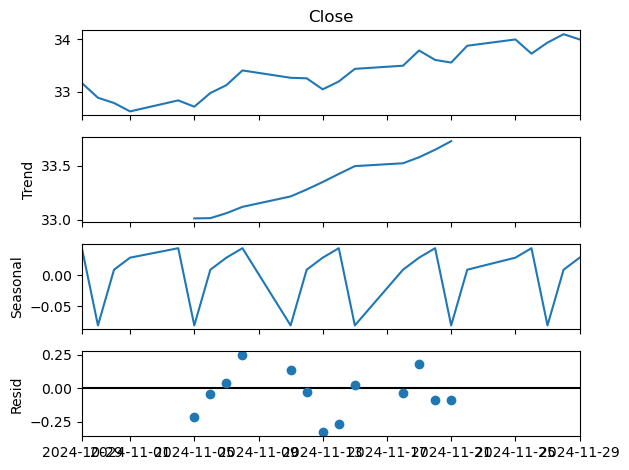

In [58]:
decomposition.plot()
plt.show()

#### Testing for Stationary Points

In [63]:
def test_stationarity(timeseries):

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    if dftest[0] < dftest[4]["5%"]:
        print('Reject H0 - Time Series is stationary')
    else:
        print('Failed to reject H0 - Time series is non-stationary')


test_stationarity(closed_prices_1month)

Results of Dickey-Fuller Test:
Test Statistic                  1.384714
p-value                         0.997044
#Lags Used                      9.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64
Failed to reject H0 - Time series is non-stationary


#### SARIMA Model

In [91]:
sarima_model_aic = pm.auto_arima(closed_prices_1month, seasonal=True, m=12,
                                 information_criterion='aic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4.097, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=32.229, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-3.401, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=238.481, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-3.830, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-1.827, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1.829, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=16.103, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-0.475, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.888 seconds


In [92]:
sarima_model_aic.set_params()

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [93]:
sarima_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.915
Date:                Fri, 29 Nov 2024   AIC                             -3.830
Time:                        16:03:57   BIC                             -0.296
Sample:                    10-29-2024   HQIC                            -2.893
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1232      3.306      0.945      0.345      -3.357       9.603
ar.L1          0.9067      0.099      9.162      0.000       0.713       1.101
sigma2         0.0362      0.020      1.830      0.067      -0.003       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
sarima_model_bic = pm.auto_arima(closed_prices_1month, seasonal=True, m=12,
                                 information_criterion='bic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=13.521, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=34.585, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=1.311, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=239.659, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=-0.296, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=2.885, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=2.883, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=19.638, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=5.415, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.485 seconds


In [95]:
sarima_model_bic.set_params()

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [98]:
sarima_model_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.915
Date:                Fri, 29 Nov 2024   AIC                             -3.830
Time:                        16:04:18   BIC                             -0.296
Sample:                    10-29-2024   HQIC                            -2.893
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1232      3.306      0.945      0.345      -3.357       9.603
ar.L1          0.9067      0.099      9.162      0.000       0.713       1.101
sigma2         0.0362      0.020      1.830      0.067      -0.003       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
sarima_aic_model = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month)
sarima_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.915
Date:                Fri, 29 Nov 2024   AIC                             -3.830
Time:                        16:04:48   BIC                             -0.296
Sample:                    10-29-2024   HQIC                            -2.893
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1232      3.306      0.945      0.345      -3.357       9.603
ar.L1          0.9067      0.099      9.162      0.000       0.713       1.101
sigma2         0.0362      0.020      1.830      0.067      -0.003       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Model Diagnosis

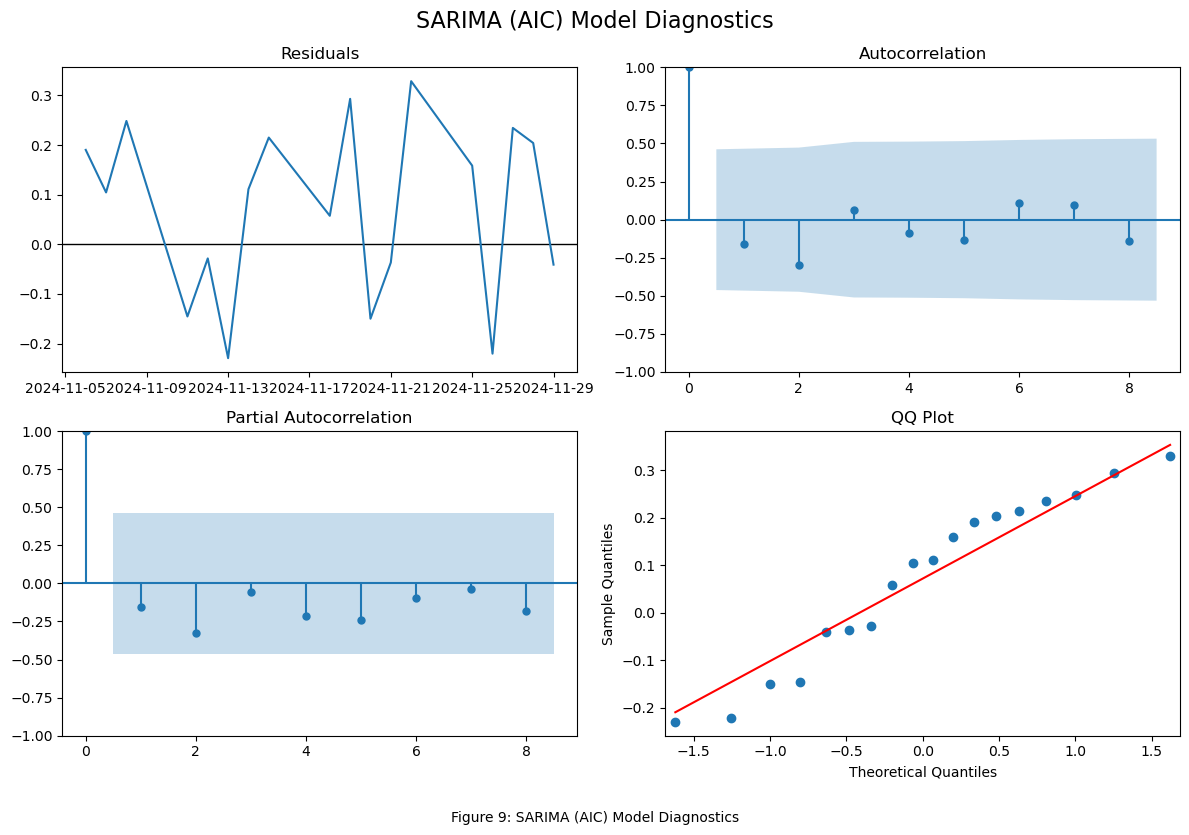

In [100]:
sarima_aic_resid = sarima_aic_model.resid()

if isinstance(sarima_aic_resid.index, pd.PeriodIndex):
    sarima_aic_resid.index = sarima_aic_resid.index.to_timestamp()

resid_no_initial_aic = sarima_aic_resid[6:]

# Plot residuals manually
fig_sarima_aic, ax_sarima_aic = plt.subplots(2, 2, figsize=(12, 8))
fig_sarima_aic.suptitle("SARIMA (AIC) Model Diagnostics", fontsize=16)
ax_sarima_aic[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_sarima_aic[0, 0].plot(resid_no_initial_aic)
ax_sarima_aic[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(resid_no_initial_aic,
                         ax=ax_sarima_aic[0, 1], alpha=0.05, lags=8)

# PACF plot
sm.graphics.tsa.plot_pacf(resid_no_initial_aic,
                          ax=ax_sarima_aic[1, 0], alpha=0.05, lags=8)

# QQ plot
sm.qqplot(resid_no_initial_aic, line='s', ax=ax_sarima_aic[1, 1])
ax_sarima_aic[1, 1].set_title("QQ Plot")

plt.tight_layout()
plt.show()

In [104]:
sarima_bic_model = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month)
sarima_bic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                   4.915
Date:                Fri, 29 Nov 2024   AIC                             -3.830
Time:                        16:06:10   BIC                             -0.296
Sample:                    10-29-2024   HQIC                            -2.893
                         - 11-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1232      3.306      0.945      0.345      -3.357       9.603
ar.L1          0.9067      0.099      9.162      0.000       0.713       1.101
sigma2         0.0362      0.020      1.830      0.067      -0.003       0.075
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.88   Prob(JB):                         0.39
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

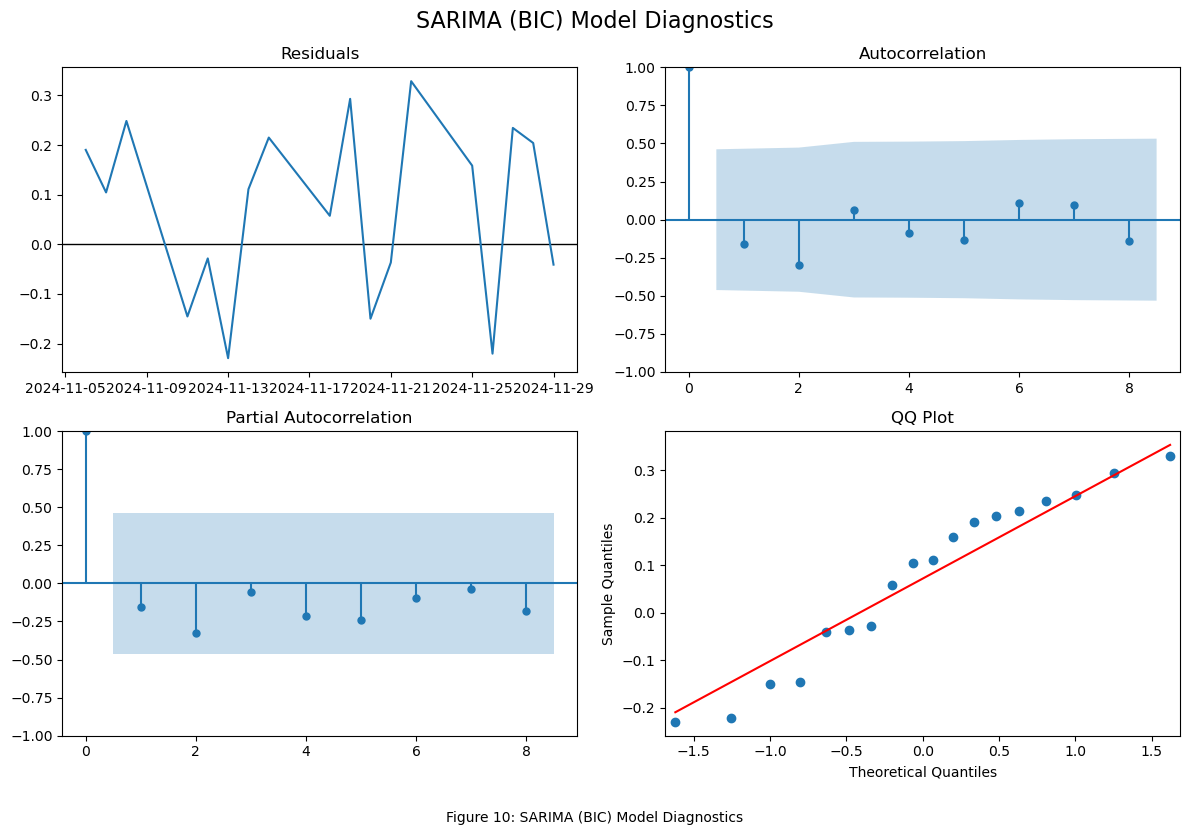

In [105]:
sarima_bic_resid = sarima_bic_model.resid()

if isinstance(sarima_bic_resid.index, pd.PeriodIndex):
    sarima_bic_resid.index = sarima_bic_resid.index.to_timestamp()

resid_no_initial_bic = sarima_bic_resid[6:]

# Plot residuals manually
fig_sarima_bic, ax_sarima_bic = plt.subplots(2, 2, figsize=(12, 8))
fig_sarima_bic.suptitle("SARIMA (BIC) Model Diagnostics", fontsize=16)
ax_sarima_bic[0, 0].axhline(0, color='black', lw=1)

# Plot residuals
ax_sarima_bic[0, 0].plot(resid_no_initial_bic)
ax_sarima_bic[0, 0].set_title("Residuals")

# ACF plot
sm.graphics.tsa.plot_acf(resid_no_initial_bic,
                         ax=ax_sarima_bic[0, 1], alpha=0.05, lags=8)

# PACF plot
sm.graphics.tsa.plot_pacf(resid_no_initial_bic,
                          ax=ax_sarima_bic[1, 0], alpha=0.05, lags=8)

# QQ plot
sm.qqplot(resid_no_initial_bic, line='s', ax=ax_sarima_bic[1, 1])
ax_sarima_bic[1, 1].set_title("QQ Plot")


plt.tight_layout()
plt.show()

##### Plotting SARIMA Model Forecasts

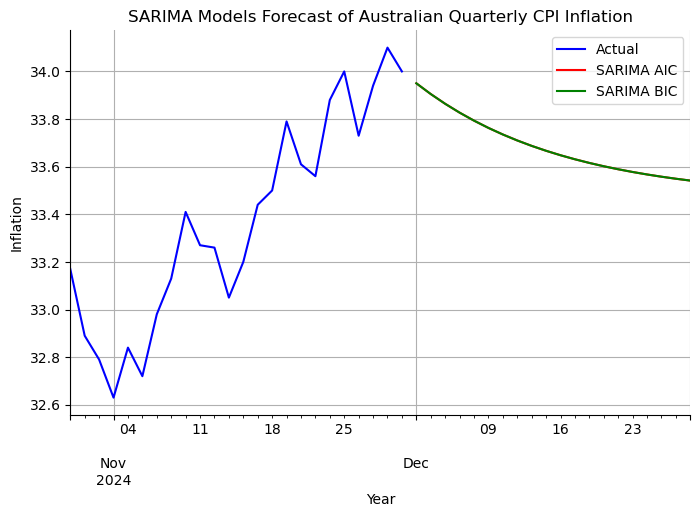

In [109]:
# Plot the forecast of the SARIMA model
fig_sarima_forecast, ax_sarima_forecast = plt.subplots(figsize=(8, 5))
closed_prices_1month.plot(color='b', ax=ax_sarima_forecast)
sarima_aic_model.predict(20).plot(color='r', ax=ax_sarima_forecast)
sarima_bic_model.predict(20).plot(color='g', ax=ax_sarima_forecast)
ax_sarima_forecast.set_xlabel('Year')
ax_sarima_forecast.set_ylabel('Inflation')
ax_sarima_forecast.set_title(
    'SARIMA Models Forecast of Australian Quarterly CPI Inflation')
sns.despine()
plt.legend(loc='best', labels=['Actual', 'SARIMA AIC', 'SARIMA BIC'])
plt.grid()
plt.show()

##### Model Evaluation

In [112]:
validation = closed_prices_1month['2024-11-06':].index
start = closed_prices_1month.index.get_loc('2024-11-06')

sarima_aic_pred = []
sarima_bic_pred = []

for i in range(start, len(closed_prices_1month)):

    sarima_aic_model_ = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                                 suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month.iloc[:i])

    sarima_aic_pred.append(sarima_aic_model_.predict(n_periods=1)[-1])

    sarima_bic_model_ = pm.ARIMA(order=(1, 0, 0), seasonal_order=(0, 0, 0, 12), solver='lbfgs', maxiter=200,
                                 suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(closed_prices_1month.iloc[:i])

    sarima_bic_pred.append(sarima_bic_model_.predict(n_periods=1)[-1])

columns = ['SARIMA (AIC)', 'SARIMA (BIC)']
results = np.vstack([sarima_aic_pred, sarima_bic_pred]).T

In [115]:
# Create a table to store the MSE values for each model
table = pd.DataFrame(0.0, index=results.columns, columns=['MSE'])

# Calculate RMSE for each model compared to the actual values
for i in range(len(results.columns)):
    table.iloc[i, 0] = mean_squared_error(
        closed_prices_1month['2024-11-06':], results.iloc[:, i])

table = table.round(3)

table.sort_values(by='MSE', inplace=True)

table

,MSE
SARIMA (AIC),0.051
SARIMA (BIC),0.051


## Data for 1 year